In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd /proj/som

/proj/som


In [4]:
import torch
from som import UnsupervisedDataset, SomInterpretation, UnsupervisedDataBunch, SomLearner, Som, cluster_loss, neigh_square, neigh_gauss, map_diff_standard

In [5]:
from torch import Tensor
from sklearn.datasets import load_iris
from typing import Tuple
from itertools import combinations_with_replacement, product

import random
import numpy as np
import matplotlib.pyplot as plt

def colors_github():
    # Set color dataset
    colors = np.empty((0,3), float)
    colors = np.append(colors, np.array([[0, 0, 0]]), axis=0)
    colors = np.append(colors, np.array([[1, 1, 1]]), axis=0)
    for i in range(10):
        colors = np.append(colors, np.array([[0, 0, random.random()]]), axis=0)
        colors = np.append(colors, np.array([[0, random.random(), 0]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), 0, 0]]), axis=0)
        colors = np.append(colors, np.array([[1, 1, random.random()]]), axis=0)
        colors = np.append(colors, np.array([[1, random.random(), 1]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), 1, 1]]), axis=0)
        colors = np.append(colors, np.array([[0, random.random(), random.random()]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), 0]]), axis=0)
        colors = np.append(colors, np.array([[1, random.random(), random.random()]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), 1]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), random.random()]]), axis=0)
    x = torch.tensor(colors)
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.03
    bs = 10
    epochs = 30
    return x, y, labels, map_size, alpha, bs, epochs

def iris():
    "Loads the IRIS dataset into two tensors."
    iris = load_iris()
    x = torch.tensor(iris.data)
    y = torch.tensor(iris.target)
    labels = iris.feature_names
    map_size = (4,4)
    alpha = 0.3
    bs = 10
    epochs = 30
    return x, y, labels, map_size, alpha, bs, epochs

def colors_uniform():
    k = 60
    x = [list(x) for x in product(list(range(k)), repeat=3)]
    from random import shuffle
    shuffle(x)
    x = torch.FloatTensor(x) * (255 / (k-1));
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.03
    bs = 128
    epochs = 30
    return x, y, labels, map_size, alpha, bs, epochs

def colors(n: int = 11000):
    "Loads a dataset containing all possible RGB color combinations"
#     x = torch.zeros(n, 3).normal_(mean=80.0, std=127.0).long().float()
    x = torch.zeros(n, 3).uniform_(0, 255).long().float()
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.03
    bs = 50
    epochs = 100
    return x, y, labels, map_size, alpha, bs, epochs


def colors_small():
    "Loads a dataset containing a small number of RGB color combinations"
    x = torch.FloatTensor([
        [3, 255, 0],
        [0, 247, 3],
        [0, 252, 5],
        [3, 239, 8],
        [0, 232, 3],
        [3, 255, 0],
        [0, 250, 5],
        [255, 3, 0],
        [247, 3, 0],
        [252, 5, 0],
        [239, 8, 3],
        [232, 0, 3],
        [255, 3, 3],
        [249, 5, 3],
        [247, 3, 5],
        [3, 0, 255],
        [3, 0, 247],
        [5, 0, 252],
        [8, 2, 239],
        [0, 3, 232],
        [3, 3, 255],
        [5, 3, 249],
        [3, 5, 247],
        [8, 3, 234],
        [3, 5, 247],
        [5, 3, 234],
    ])
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (3, 3)
    alpha = 0.01
    bs = 4
    epochs = 100
    return x, y, labels, map_size, alpha, bs, epochs

def uniform(n: int = 11000, s: int = 3):
    "Loads a uniform dataset"
    x = torch.randn(n, s)
    y = None
    labels = list(range(s))
    map_size = (6, 6)
    alpha = 0.03
    bs = 50
    epochs = 150
    return x, y, labels, map_size, alpha, bs, epochs
    

In [6]:
neigh_fn = neigh_square
map_diff_fn = map_diff_standard

## Create the dataset

We use one of the data loading functions defined above together with the `UnsupervisedDataBunch` class.

In [7]:
x, y, labels, map_size, alpha, bs, epochs = colors_uniform()

In [8]:
db = UnsupervisedDataBunch(x, valid=0.0, sampler='seq', bs=bs)

In [9]:
# db.normalize('minmax')

In [10]:
db.train_ds.tensors[0]

tensor([[237.7119,  51.8644, 237.7119],
        [ 73.4746,  82.1186, 112.3729],
        [ 47.5424, 185.8475,  17.2881],
        ...,
        [ 17.2881,  86.4407,  56.1864],
        [121.0170, 155.5932, 138.3051],
        [ 25.9322,  82.1186,  47.5424]])

In [11]:
n_batches = x.shape[0] // bs
alpha, bs, epochs, n_batches

(0.03, 128, 30, 1687)

## Create the Learner

First, let's define the map size:

In [12]:
size = (map_size[0], map_size[1], x.shape[-1])
size

(10, 10, 3)

Then we can create a Som model of the required size and pass it to a `SomLearner`:

In [13]:
# learn = SomLearnerFast(db, som)
# learn = SomLearnerFast(db, som, loss_func=None)
learn = SomLearner(db, Som(size, alpha=alpha, neigh_fn=neigh_fn, map_diff_fn=map_diff_fn), visualize=True)
learn.model

Som(
            size=(10, 10), neuron_size=3, alpha=tensor([0.0300], device='cuda:0'), sigma=tensor([5.], device='cuda:0')),
            dist_fn=squared_dist, neigh_fn=neigh_square, map_diff_fn=<function map_diff_standard at 0x7efb1c84b950>)

LR Find doesn't work at the moment, since it is useless on a pre-trained SOM and there is no way to pass the LR parameter directly to the model.

In [14]:
# learn.lr_find()

In [15]:
# learn.recorder.plot()

## Performance check

In [16]:
s = Som(size, neigh_fn=neigh_fn, map_diff_fn=map_diff_fn)
s

Som(
            size=(10, 10), neuron_size=3, alpha=tensor([0.0030], device='cuda:0'), sigma=tensor([5.], device='cuda:0')),
            dist_fn=squared_dist, neigh_fn=neigh_square, map_diff_fn=<function map_diff_standard at 0x7efb1c84b950>)

In [17]:
db.train_ds.tensors[0].shape

torch.Size([216000, 3])

In [18]:
# def myfun():
#     for _ in range(len(db.train_ds.tensors[0]) // bs):
#         xb, yb = db.one_batch()
#         out = s.forward(xb)
#         s.backward()
# #         loss = cluster_loss(out, xb, s, device=s.device)
# #         loss.backward()

In [19]:
# %time myfun()

In [20]:
# xb, yb = db.one_batch()

## Training the model

This uses various SOM callback classes by default to visualize weights and update hyperparameters.

In [21]:
# %matplotlib notebook
# learn.fit(epochs)

## Hyperparams exploration

In [22]:
recorder = []

def train_som(epochs, hyperparams):
    learn = SomLearner(db, Som(size, recorder, neigh_fn=neigh_fn, map_diff_fn=map_diff_fn), visualize=True, **hyperparams)
    print(learn.model.weights.shape)
    learn.fit(epochs)
    return learn

In [24]:
def build_hypers(finetune_epoch_pct, lr):
    return dict(finetune_epoch_pct=finetune_epoch_pct, lr=lr)

In [25]:
hypers = [
#     (10, build_hypers(0.2, (0.09, 0.03))),
    (100, build_hypers(0.5, (0.3, 0.2))),
#     (50, build_hypers(0.8, (0.09, 0.2))),
]

torch.Size([10, 10, 3])


<IPython.core.display.Javascript object>


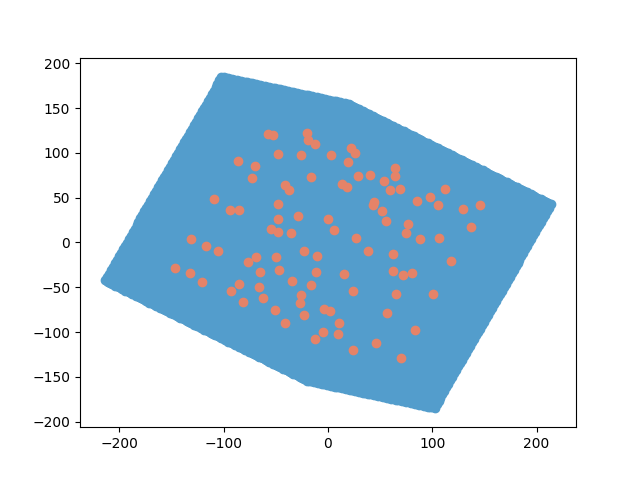

<IPython.core.display.Javascript object>


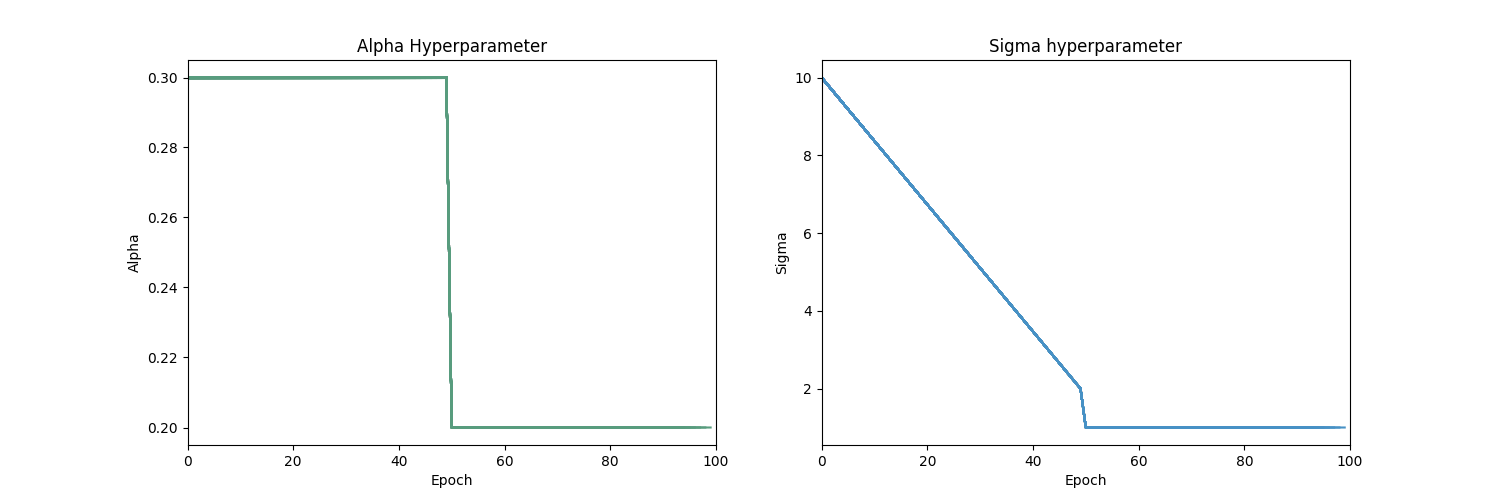

epoch,train_loss,valid_loss,time
0,0.000000,#na#,00:03
1,0.000000,#na#,00:03
2,0.000000,#na#,00:03
3,0.000000,#na#,00:03
4,0.000000,#na#,00:03
5,0.000000,#na#,00:03
6,0.000000,#na#,00:03
7,0.000000,#na#,00:03
8,0.000000,#na#,00:03
9,0.000000,#na#,00:03


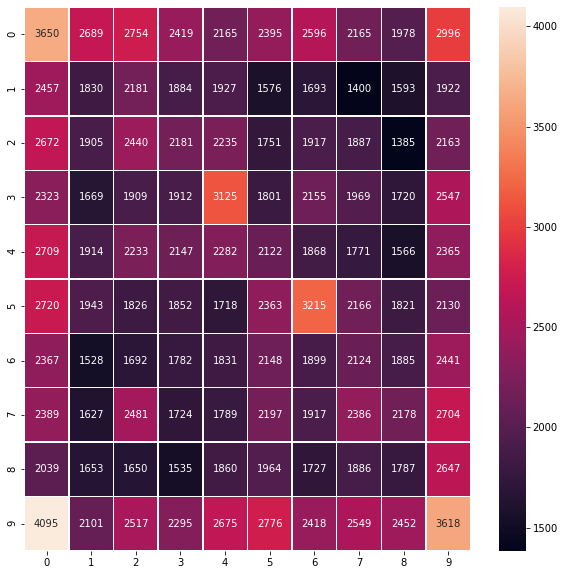

In [34]:
learns = []

for hp in hypers:
    %matplotlib notebook
    learn = train_som(hp[0], hp[1])
    learns.append(learn)
    %matplotlib inline
    SomInterpretation.from_learner(learn).show_hitmap()

In [85]:
delta, n, ed = recorder[0]['delta'], recorder[0]['n'], recorder[0]['ed']
delta.shape, n.shape, ed.shape

(torch.Size([128, 10, 10, 3]),
 torch.Size([128, 10, 10]),
 torch.Size([128, 10, 10, 3]))

In [86]:
import matplotlib.pyplot as plt

In [87]:
learns[0].model.sigma

1.0

In [88]:
n.shape

torch.Size([128, 10, 10])

In [89]:
delta[3][0][0]

tensor([-4.5615,  1.2658, -3.4949])

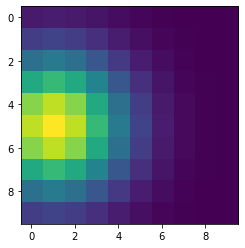

In [90]:
plt.imshow(n[24])

In [91]:
n.min()

tensor(9.2136e-08)

In [92]:
learns[0].model.weights.view(-1, 3).min()

tensor(29.4187, device='cuda:0')

In [93]:
# a.view(30, -1, 3).max(dim=0)

---

In [94]:
learn = learns[0]

In [95]:
interp = SomInterpretation.from_learner(learn)

NameError: name 'a' is not defined

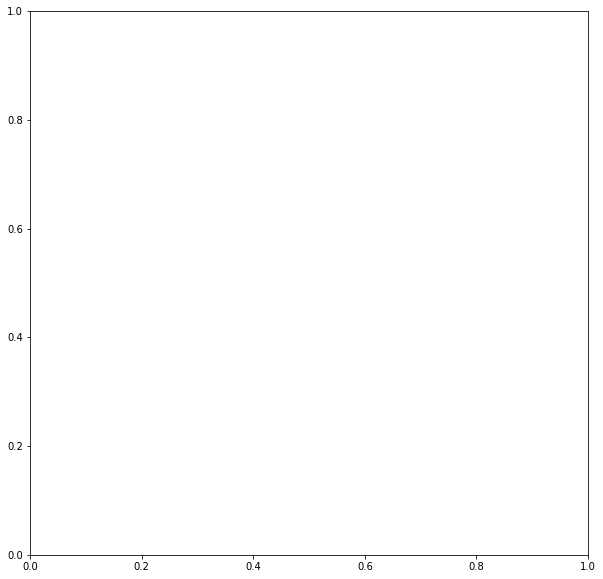

In [96]:
%matplotlib inline
interp.show_hitmap()

In [ ]:
x[:10]

In [ ]:
interp.show_weights()

In [ ]:
interp.show_feature_heatmaps(labels=labels)

In [ ]:
# v.show(som, what='codebook')

In [ ]:
!pip install git+https://github.com/sevamoo/sompy

In [ ]:
import sompy

In [ ]:
som = sompy..somFactory.build(x.cpu().numpy(), map_size, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='random', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info', train_rough_len=22, train_finetune_len=8)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8) 

In [ ]:
v.show??

In [ ]:
h = sompy.hitmap.HitMapView(10, 10, 'test')

In [ ]:
# h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

In [ ]:
sompy.hitmap.HitMapView(10, 10, 'test').show

In [ ]:
v.show(som, what='cluster')